In [1]:
import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import mlab

import os
import json
from glob import glob

from uncertainties import unumpy as unp
from uncertainties import ufloat, umath, Variable

from options import *
from constants import *

nom_vals = unp.nominal_values
std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

In [2]:
def load(dataset: str):

    if dataset.endswith('.dat'):
        with open(dataset.replace("raw.dat", "params.json"), "r") as file:
            params = json.load(file)
        raw_data = np.fromfile(dataset, np.complex64)
        spectrum, frequencies = mlab.psd(raw_data, NFFT=NFFT, Fs=SAMPLE_RATE)
        frequencies += params['frequency']
    elif dataset.endswith('.npy'):
        with open(dataset.replace("raw.npy", "params.json"), "r") as file:
            params = json.load(file)

        spectrum = np.load(dataset, allow_pickle=False)
        frequencies = None
    else:
        raise NotImplementedError

    return (spectrum, frequencies), params

In [3]:
data = []
noise = None
freq = None

files = glob("../data/h_*.npy")
files.sort(key=lambda s: ''.join(s.split('_')[2:]))

(noise, freq), _ = load("../data/bc_test3_2025_02_28_13_31_31_raw.dat")

for file in files:
    (spectrum, _), params = load(file)
    params['l'] = ufloat(file.split('data/h_')[1].split('_')[0], 1)
    data.append((spectrum, params))


In [4]:
def gaussian(x: np.ndarray, A: float, B: float, mu: float, sigma: float) -> np.ndarray:
    return A + B * np.exp(-(x - mu)**2 / (2 * sigma**2))

In [5]:
def deg2rad(deg: float | Variable) -> float | Variable:
    return np.pi * deg / 180

In [6]:
def calculate_average(spectrum: np.ndarray) -> float:
    idx = np.r_[200:500,550:850]
    return np.mean(spectrum[idx])

In [7]:
def normalise_data(signal: np.ndarray, noise: np.ndarray) -> np.ndarray:
    return signal / noise

In [8]:
def clean_up(signal: np.ndarray, w: int = 10) -> np.ndarray:
    # cleaned = np.convolve(signal, np.ones(w), 'same') / w
    cleaned = sc.signal.medfilt(signal, w)
    return cleaned

In [9]:
def calculate_relative_velocity(measured_frequency: float | Variable) -> float | Variable:
    return sc.constants.c * (H21 - measured_frequency) / measured_frequency

In [10]:
def bad_distance_estimate(relative_velocity: float | Variable, galactic_longitude: float | Variable) -> float | Variable:
    galactic_rad = deg2rad(galactic_longitude)
    d = relative_velocity / OORT_A / unp.sin(2 * galactic_rad)
    return abs(d)

In [11]:
def velocity_vector_method(relative_velocity: float | Variable, galactic_longitude: float | Variable) -> float | Variable:
    galactic_rad = deg2rad(galactic_longitude)

    d = bad_distance_estimate(relative_velocity, galactic_longitude)
    R = unp.sqrt(R0**2 + d**2 - 2 * R0 * d * unp.cos(galactic_rad))

    V_hydrogen_cloud = R / R0 * (relative_velocity / unp.sin(galactic_rad) + V0)
    return V_hydrogen_cloud, R

In [12]:
def matteo_method(relative_velocity: float | Variable, galactic_longitude: float | Variable) -> float | Variable:
    galactic_rad = deg2rad(galactic_longitude)

    d = bad_distance_estimate(relative_velocity, galactic_longitude)
    R = unp.sqrt(R0**2 + d**2 - 2 * R0 * d * unp.cos(galactic_rad))

    cos_alpha = (R**2 + d**2 - R0**2) / (2 * R * d)
    V_hydrogen_cloud = (relative_velocity + V0 * unp.sin(galactic_rad)) / unp.sqrt(1 - cos_alpha**2)
    return V_hydrogen_cloud, R

In [13]:
def tangent_method(relative_velocity: float | Variable, galactic_longitude: float | Variable) -> float | Variable:
    galactic_rad = deg2rad(galactic_longitude)
    V_hydrogen = relative_velocity + V0 * unp.sin(galactic_rad)
    R = R0 * unp.sin(galactic_rad)
    # R = EARTH_GALACTIC_CENTER * unp.sin(galactic_rad) * V0 / (V0 * unp.sin(galactic_rad) - relative_velocity)
    return V_hydrogen, R

In [14]:
def processing_tangent(freq: np.ndarray, spectrum: np.ndarray, params: dict, noise: np.ndarray, peaks_idx: list[int] = None, display: bool = True) -> Variable:
    cleaned_signal = clean_up(normalise_data(spectrum, noise), w=5)
    
    if peaks_idx is None:
        max_idx = np.argmax(cleaned_signal)
        freq_of_max = ufloat(freq[max_idx], 0.00002e9)  # estimated error based on vibes
        # print(f"Maximum found at {freq[max_idx]} Hz")
    else:
        if len(peaks_idx) > 1: print("WARNING: only uses the first value currently")
        freq_of_max = ufloat(freq[peaks_idx[0]], 0.00002e9)  # estimated error based on vibes

    relative_velocity = calculate_relative_velocity(freq_of_max)
    
    l: float = params.get('l', 0)
    actual_velocity: Variable = None
    radius: Variable = None
    # Inner circle
    if l < 90:
        actual_velocity, radius = tangent_method(relative_velocity, l)
    # Outer circle
    elif l < 270:
        print(f"WARNING: using the bad method for {l=:.0f}")
        actual_velocity, radius = matteo_method(relative_velocity, l)

    if display:
        print(f"Estimated relative velocity ({l=:.1uP}): {relative_velocity/1000:.3upP} km/s")
        print(f"Estimated actual velocity ({l=:.1uP}): {actual_velocity/1000:.3upP} km/s")
        plt.semilogy(freq, cleaned_signal)
        plt.axvline(H21, c='r', label='Base H21', ls='--')
        plt.axvline(freq_of_max.n, c='magenta', label='Shifted peak')
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("Signal-to-noise ratio")
        plt.legend()
    
    distance_est = bad_distance_estimate(relative_velocity, l)

    return distance_est, actual_velocity, radius, l

In [15]:
def processing_vector(freq: np.ndarray, spectrum: np.ndarray, params: dict, noise: np.ndarray, peaks_idx: list[int] = None, display: bool = True) -> Variable:
    cleaned_signal = clean_up(normalise_data(spectrum, noise), w=5)
    
    if peaks_idx is None:
        max_idx = np.argmax(cleaned_signal)
        freq_of_max = ufloat(freq[max_idx], 0.00002e9)  # estimated error based on vibes
        # print(f"Maximum found at {freq[max_idx]} Hz")
    else:
        if len(peaks_idx) > 1: print("WARNING: only uses the first value currently")
        freq_of_max = ufloat(freq[peaks_idx[0]], 0.00002e9)  # estimated error based on vibes

    relative_velocity = calculate_relative_velocity(freq_of_max)
    
    l: float = params.get('l', 0)
    actual_velocity: Variable = None
    radius: Variable = None
    # Inner circle
    if l < 90:
        actual_velocity, radius = velocity_vector_method(relative_velocity, l)
    # Outer circle
    elif l < 270:
        print(f"WARNING: using the bad method for {l=:.0f}")
        actual_velocity, radius = matteo_method(relative_velocity, l)
    else:
        print("brotha uuuhhh")

    if display:
        print(f"Estimated relative velocity ({l=:.1uP}): {relative_velocity/1000:.3upP} km/s")
        print(f"Estimated actual velocity ({l=:.1uP}): {actual_velocity/1000:.3upP} km/s")
        plt.semilogy(freq, cleaned_signal)
        plt.axvline(H21, c='r', label='Base H21', ls='--')
        plt.axvline(freq_of_max.n, c='magenta', label='Shifted peak')
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("Signal-to-noise ratio")
        plt.legend()
    
    distance_est = bad_distance_estimate(relative_velocity, l)

    return distance_est, actual_velocity, radius, l

In [16]:
# curve_fig, curve_ax = plt.subplots()

# for i in range(len(data)):
#     # i = 20
#     s, p = data[i]
#     ss = to_dB(clean_up(normalise_data(s, noise), w=5))
#     peaks_idx = sc.signal.find_peaks(ss, height=0.05)[0]
#     if len(peaks_idx) == 0:
#         print(f"Found no peaks for l={p['l']}")
#         continue
#     vels = calculate_relative_velocity(freq[peaks_idx])
#     all_vels = calculate_relative_velocity(freq)

#     fig, ax = plt.subplots(1, 2, figsize=(7, 3))
#     ax[0].scatter(vels[vels > 0], ss[peaks_idx][vels > 0])
#     ax[0].scatter(np.abs(vels[vels < 0]), ss[peaks_idx][vels < 0])
#     ax[0].plot(all_vels[all_vels > 0], ss[all_vels > 0])
#     ax[0].plot(np.abs(all_vels[all_vels < 0]), ss[all_vels < 0])
#     ax[0].set_title("speed")

#     max_amplitude = np.max(ss[peaks_idx])
#     threshold = max_amplitude - 0.1
#     relative_velocity_max = np.max(np.abs(vels[ss[peaks_idx] > threshold]))
#     print(relative_velocity_max)
#     true_velocity, radius = tangent_method(relative_velocity_max, p['l'])
#     curve_ax.scatter(radius.n, true_velocity.n / 1000)
    
#     ax[0].axvline(abs(relative_velocity_max))

#     ax[1].plot(freq, ss)
#     ax[1].scatter(freq[peaks_idx], ss[peaks_idx])
#     ax[1].axvline(H21)
#     ax[1].set_title(f"spectrum ({p['l'].n})")
#     fig.show(warn=False)
#     # plt.close()
#     # break

# curve_fig.show(warn=False)

In [17]:
all_peaks = [None] * len(data)
all_peaks[19] = [725]
all_peaks[20] = [725]

ignore = np.full(len(data), False)
ignore[17:22] = True
ignore[24:27] = True
ignore[28:32] = True
ignore[35:] = True

distances = []
velocities = []
longitudes = []
radii = []


Estimated relative velocity (l=3±1): (-16.94±4.22) km/s
Estimated actual velocity (l=3±1): (-5.42±5.70) km/s


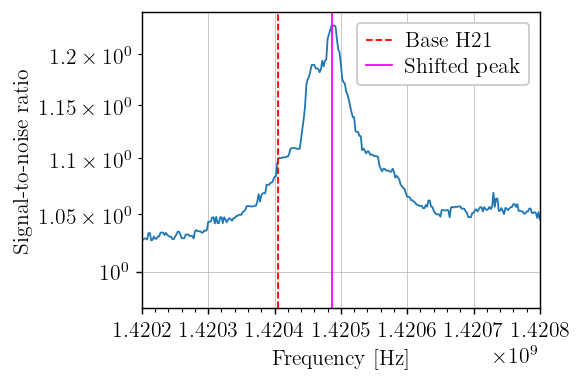

Estimated relative velocity (l=6±1): (-14.83±4.22) km/s
Estimated actual velocity (l=6±1): (8.17±5.69) km/s


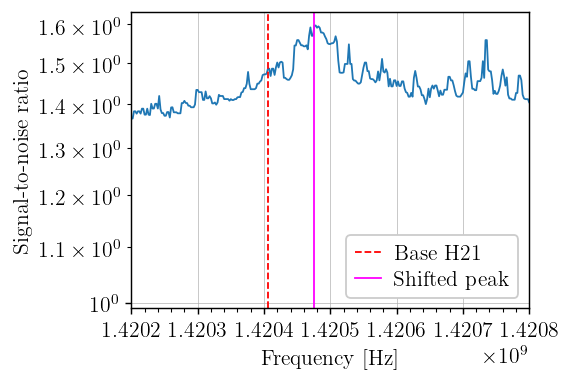

Estimated relative velocity (l=9±1): (-15.25±4.22) km/s
Estimated actual velocity (l=9±1): (19.17±5.67) km/s


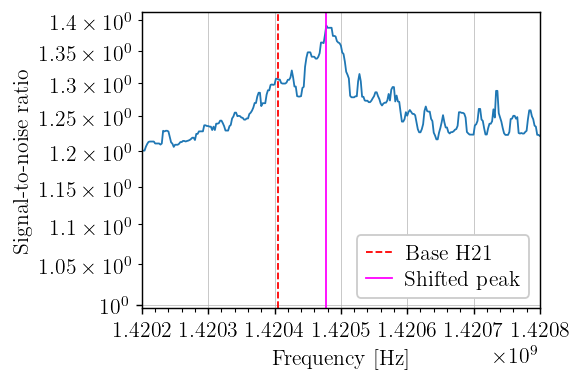

Estimated relative velocity (l=12±1): (-16.09±4.22) km/s
Estimated actual velocity (l=12±1): (29.65±5.65) km/s


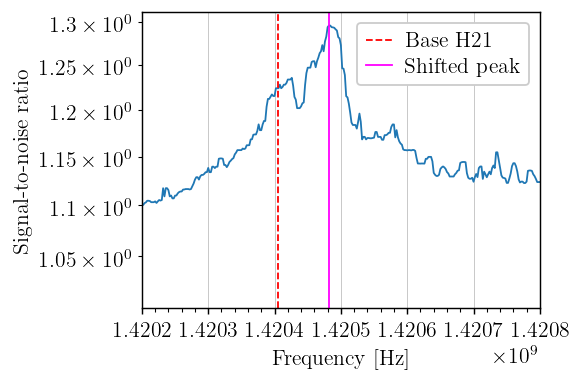

Estimated relative velocity (l=15±1): (-17.36±4.22) km/s
Estimated actual velocity (l=15±1): (39.58±5.62) km/s


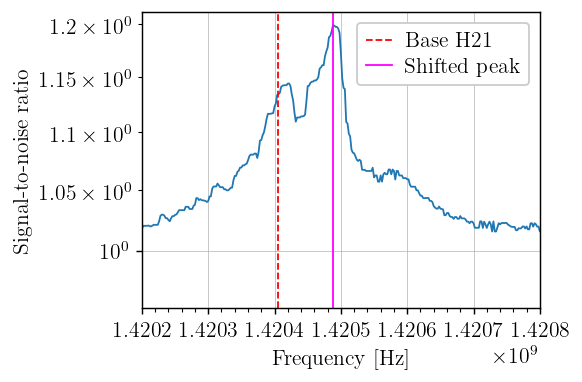

Estimated relative velocity (l=18±1): (-17.78±4.22) km/s
Estimated actual velocity (l=18±1): (50.20±5.58) km/s


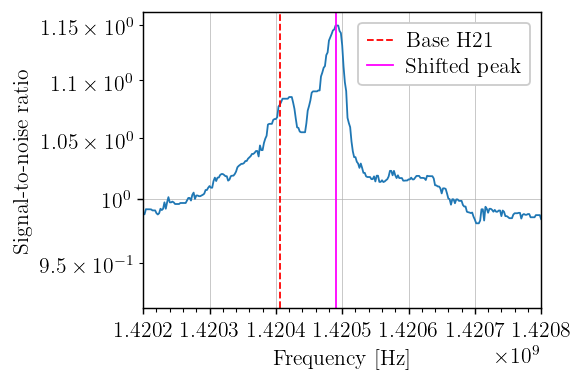

Estimated relative velocity (l=21±1): (-18.20±4.22) km/s
Estimated actual velocity (l=21±1): (60.64±5.54) km/s


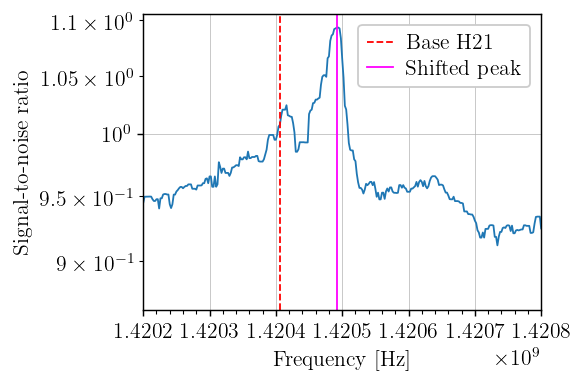

Estimated relative velocity (l=24±1): (-16.09±4.22) km/s
Estimated actual velocity (l=24±1): (73.39±5.49) km/s


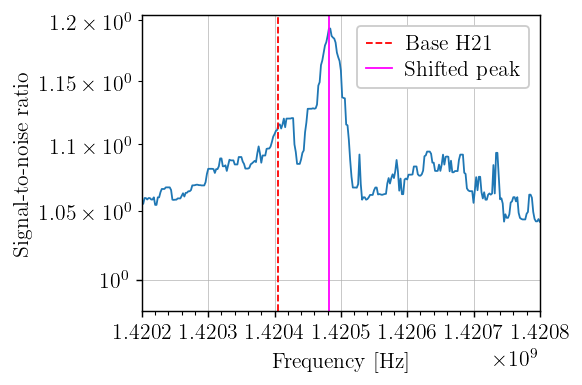

Estimated relative velocity (l=27±1): (-15.25±4.22) km/s
Estimated actual velocity (l=27±1): (84.63±5.43) km/s


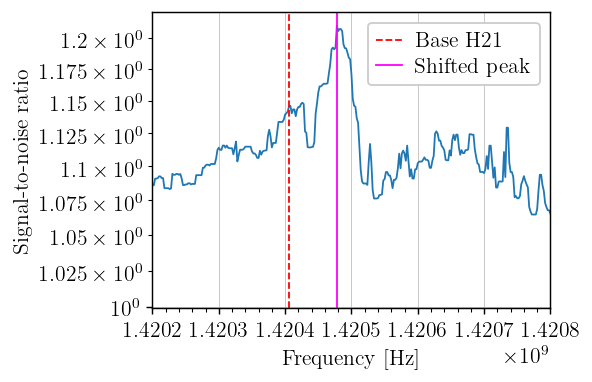

Estimated relative velocity (l=30±1): (-15.25±4.22) km/s
Estimated actual velocity (l=30±1): (94.75±5.37) km/s


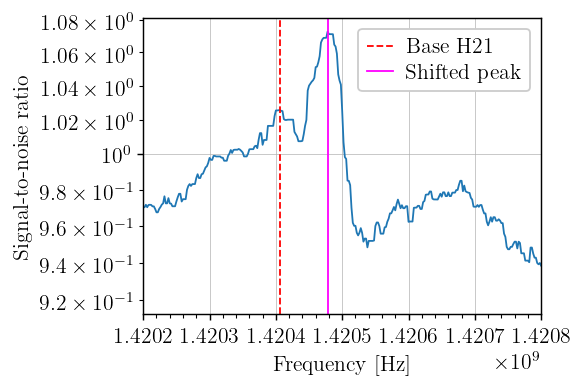

Estimated relative velocity (l=33±1): (-13.98±4.22) km/s
Estimated actual velocity (l=33±1): (105.84±5.31) km/s


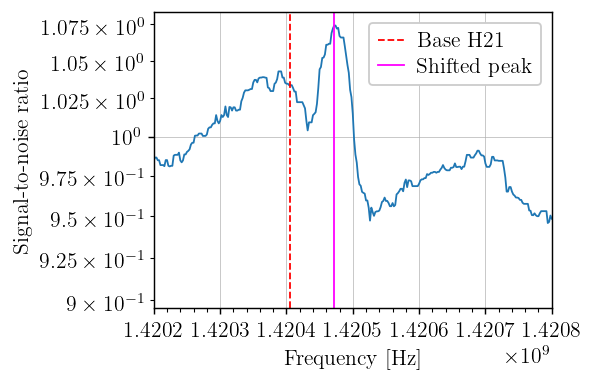

Estimated relative velocity (l=36±1): (-13.56±4.22) km/s
Estimated actual velocity (l=36±1): (115.75±5.24) km/s


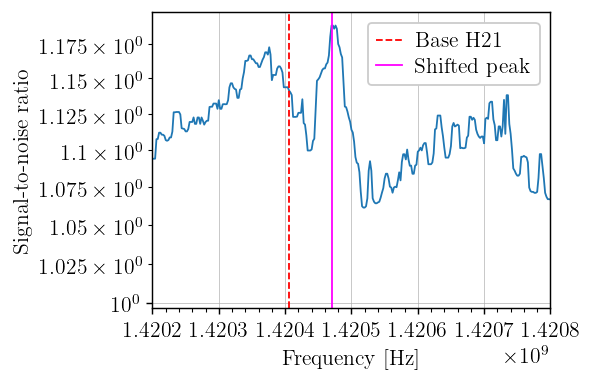

Estimated relative velocity (l=39±1): (86.09±4.22) km/s
Estimated actual velocity (l=39±1): (224.54±5.17) km/s


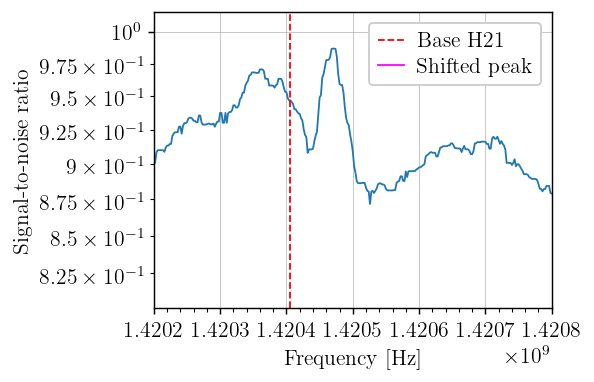

Estimated relative velocity (l=42±1): (-13.56±4.22) km/s
Estimated actual velocity (l=42±1): (133.65±5.09) km/s


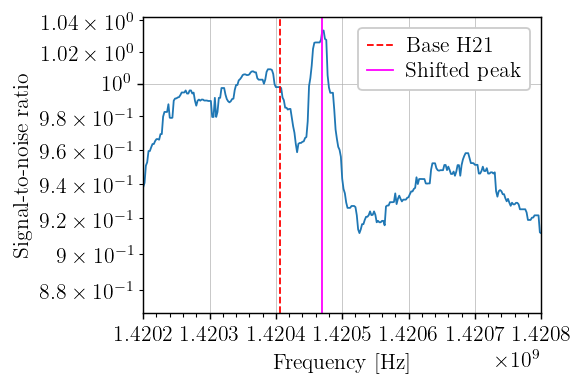

Estimated relative velocity (l=45±1): (-12.72±4.22) km/s
Estimated actual velocity (l=45±1): (142.85±5.02) km/s


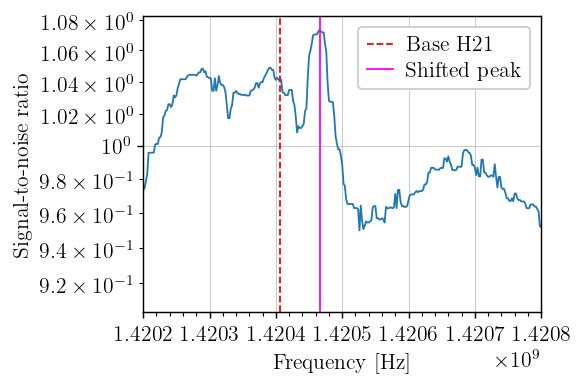

Estimated relative velocity (l=48±1): (-10.61±4.22) km/s
Estimated actual velocity (l=48±1): (152.89±4.94) km/s


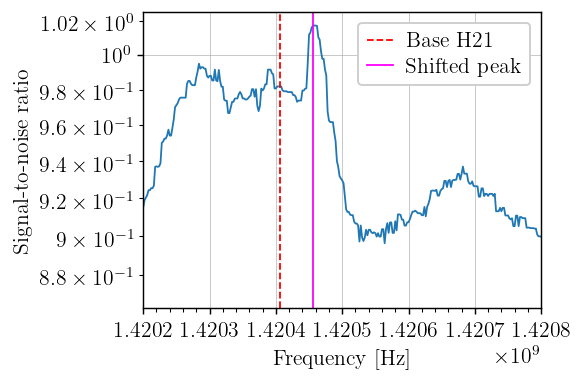

Estimated relative velocity (l=51±1): (86.09±4.22) km/s
Estimated actual velocity (l=51±1): (257.06±4.87) km/s


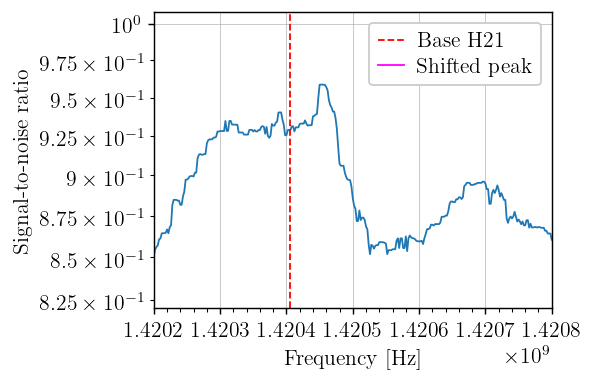

Estimated relative velocity (l=66±1): (-0.05±4.22) km/s
Estimated actual velocity (l=66±1): (200.93±4.50) km/s


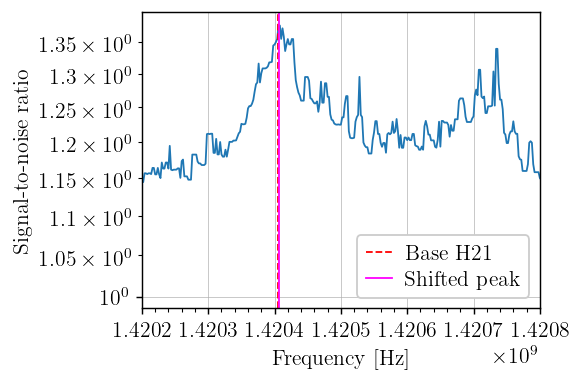

Estimated relative velocity (l=69±1): (-0.05±4.22) km/s
Estimated actual velocity (l=69±1): (205.34±4.44) km/s


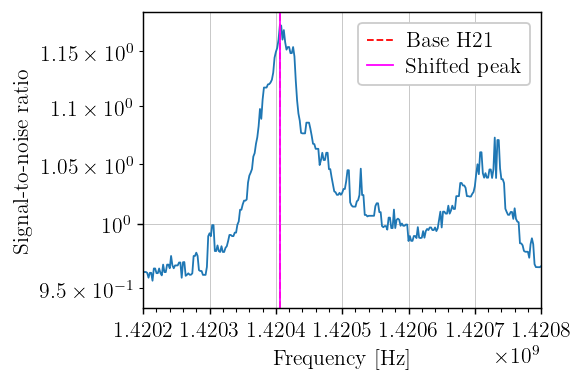

Estimated relative velocity (l=81±1): (6.28±4.22) km/s
Estimated actual velocity (l=81±1): (223.57±4.26) km/s


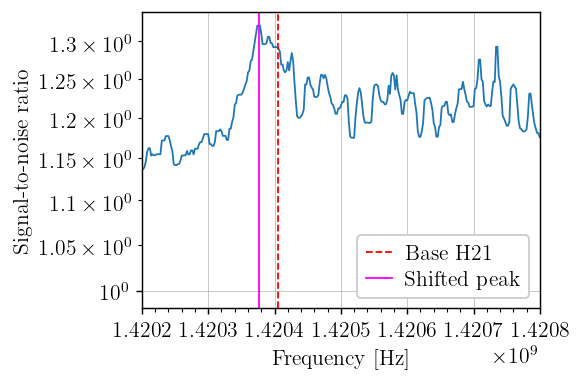

Estimated relative velocity (l=99±1): (10.50±4.22) km/s
Estimated actual velocity (l=99±1): (247.3±14.1) km/s


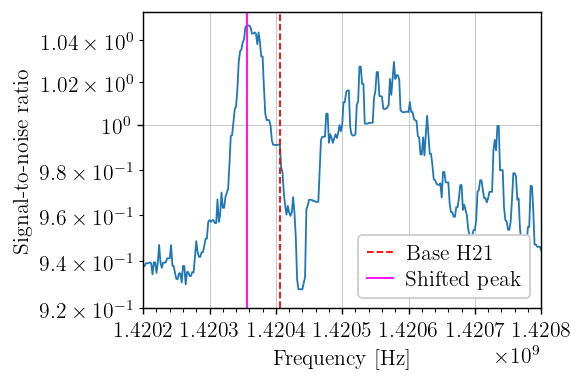

Estimated relative velocity (l=102±1): (86.09±4.22) km/s
Estimated actual velocity (l=102±1): (640.6±44.4) km/s


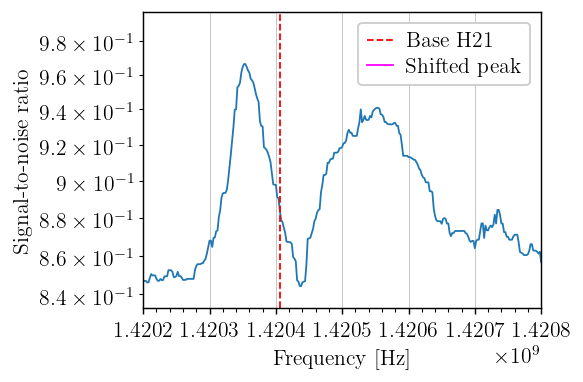

Estimated relative velocity (l=105±1): (-25.38±4.22) km/s
Estimated actual velocity (l=105±1): (225.45±2.74) km/s


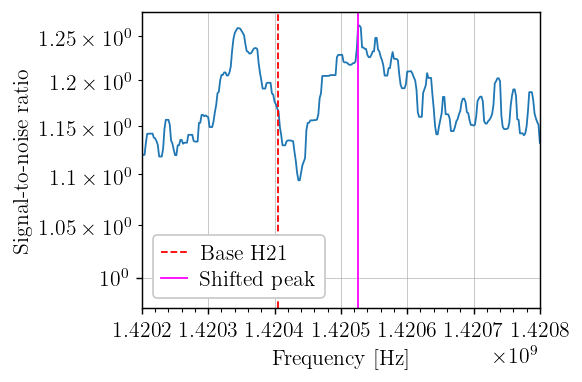

In [18]:
for i, ((spectrum, params), peaks) in enumerate(zip(data, all_peaks)):
    if (ignore[i]):
        distances.append(None)
        velocities.append(None)
        longitudes.append(None)
        radii.append(None)
    else:
        # print(f"Spectrum [{i}]")
        dist, vel , radius, l = processing_tangent(freq, spectrum, params, noise, peaks_idx=peaks, display=True)
        distances.append(dist)
        velocities.append(vel)
        longitudes.append(l)
        radii.append(radius)
        plt.xlim(1.4202e9, 1.4208e9)
        plt.show()

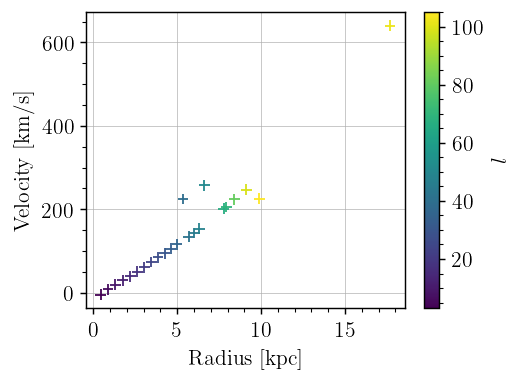

In [19]:
plt.scatter([nom_vals(R) for R in radii if R is not None], [v.n / 1000 for v in velocities if v is not None], c = [l.n for l in longitudes if l is not None])

# plt.xlim(-1,25)
# plt.ylim(-50,400)

plt.xlabel('Radius [kpc]')
plt.ylabel('Velocity [km/s]')
plt.colorbar(label="$l$")

/var/folders/s6/cl_qc4357kx9vckbb8vx6c740000gp/T/ipykernel_65298/1302952850.py:5: RuntimeWarning: invalid value encountered in sqrt
  less_bad_distances_plus = R0 * np.cos(deg2rad(longitudes_array)) + np.sqrt(R0**2 * np.cos(deg2rad(longitudes_array))**2 - (R0**2 - radii_array**2))
/var/folders/s6/cl_qc4357kx9vckbb8vx6c740000gp/T/ipykernel_65298/1302952850.py:6: RuntimeWarning: invalid value encountered in sqrt
  less_bad_distances_minus = R0 * np.cos(deg2rad(longitudes_array)) - np.sqrt(R0**2 * np.cos(deg2rad(longitudes_array))**2 - (R0**2 - radii_array**2))


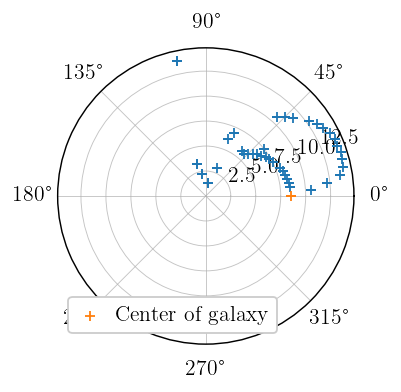

In [30]:
longitudes_array = np.array([l.n for l in longitudes if l is not None])
radii_array = np.array([nom_vals(R) for R in radii if R is not None])

bad_distances = bad_distance_estimate(np.array([v.n for v in velocities if v is not None]), longitudes_array)
less_bad_distances_plus = R0 * np.cos(deg2rad(longitudes_array)) + np.sqrt(R0**2 * np.cos(deg2rad(longitudes_array))**2 - (R0**2 - radii_array**2))
less_bad_distances_minus = R0 * np.cos(deg2rad(longitudes_array)) - np.sqrt(R0**2 * np.cos(deg2rad(longitudes_array))**2 - (R0**2 - radii_array**2))

plt.subplot(projection="polar")
# plt.scatter(longitudes_array, nom_vals(bad_distances))
plt.scatter(deg2rad(longitudes_array), less_bad_distances_plus)
# plt.scatter(longitudes_array, less_bad_distances_minus)
plt.scatter(0, R0, label="Center of galaxy")
# plt.ylim(0,30)
plt.legend()

In [21]:
for i, ((spectrum, params), peaks) in enumerate(zip(data, all_peaks)):
    if (ignore[i]):
        distances.append(None)
        velocities.append(None)
        longitudes.append(None)
        radii.append(None)
    else:
        # print(f"Spectrum [{i}]")
        dist, vel , radius, l = processing_vector(freq, spectrum, params, noise, peaks_idx=peaks, display=False)
        distances.append(dist)
        velocities.append(vel)
        longitudes.append(l)
        radii.append(radius)
        # plt.xlim(1.4202e9, 1.4208e9)
        # plt.show()

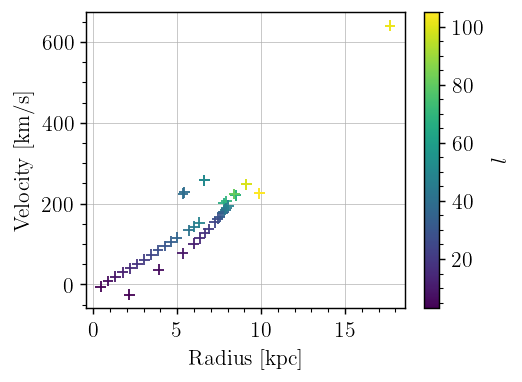

In [22]:
plt.scatter([nom_vals(R) for R in radii if R is not None], [v.n / 1000 for v in velocities if v is not None], c = [l.n for l in longitudes if l is not None])

# plt.xlim(-1,25)
# plt.ylim(-50,400)

plt.xlabel('Radius [kpc]')
plt.ylabel('Velocity [km/s]')
plt.colorbar(label="$l$")